## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-sagittal' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
horizontal_wavelet_sagittal_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/sagittal/wavelet/horizontal'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0,
 3: 3396,
 4: 98808,
 5: 524004,
 6: 2418270,
 7: 10234344,
 8: 42110360,
 9: 170911996}

Running 12760 CDFs


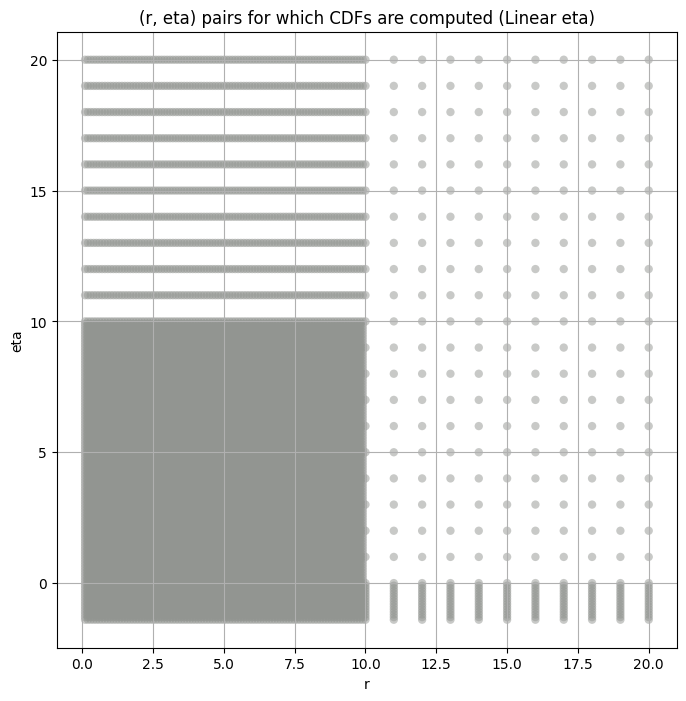

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:21<00:00, 4585.70it/s]


Layer 3


100%|██████████| 100000/100000 [00:35<00:00, 2831.81it/s]


Layer 4


100%|██████████| 100000/100000 [00:45<00:00, 2209.50it/s]


Layer 5


100%|██████████| 100000/100000 [00:42<00:00, 2339.87it/s]


Layer 6


100%|██████████| 100000/100000 [00:41<00:00, 2412.83it/s]


Layer 7


100%|██████████| 100000/100000 [00:41<00:00, 2417.92it/s]


Layer 8


100%|██████████| 100000/100000 [00:47<00:00, 2113.71it/s]


Layer 9


100%|██████████| 100000/100000 [00:47<00:00, 2091.91it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2.136796e+06,2.089662e+06,2.183364e+06,-1.757529,-1.772466,-1.739543,3396.0
4,1.684740e+05,1.600476e+05,1.771482e+05,1.874441,1.463638,2.318799,98808.0
5,8.369902e+04,7.840057e+04,8.918237e+04,4.219650,3.506101,5.112777,524004.0
6,2.650260e+04,2.454781e+04,2.854205e+04,6.584359,5.694902,7.737797,2418270.0
7,6.867342e+03,6.302964e+03,7.459079e+03,8.624499,7.535332,9.846775,10234344.0
8,9.770067e+02,8.924991e+02,1.067059e+03,9.898498,8.096569,13.575704,42110360.0
9,9.496691e+01,8.462709e+01,1.075309e+02,19.474989,11.005217,47.744520,170911996.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.136796e+06,2.136796e+06,2.088470e+06,2.050182e+06,2.016164e+06,1.985218e+06,1.927557e+06,1.874000e+06,1.824328e+06,1.776314e+06,1.730400e+06,1.599600e+06
4,1.684740e+05,1.684740e+05,1.662702e+05,1.644630e+05,1.628443e+05,1.613604e+05,1.586931e+05,1.562860e+05,1.540564e+05,1.519786e+05,1.500320e+05,1.448745e+05
5,8.369902e+04,8.369902e+04,8.216612e+04,8.104093e+04,8.005158e+04,7.914448e+04,7.750474e+04,7.601745e+04,7.464498e+04,7.336108e+04,7.215626e+04,6.892150e+04
6,2.650260e+04,2.650260e+04,2.595830e+04,2.553835e+04,2.516014e+04,2.481043e+04,2.416594e+04,2.357946e+04,2.303658e+04,2.252961e+04,2.205353e+04,2.077381e+04
7,6.867342e+03,6.867342e+03,6.705142e+03,6.576920e+03,6.463130e+03,6.358668e+03,6.168552e+03,5.996604e+03,5.838131e+03,5.690633e+03,5.552271e+03,5.180713e+03
8,9.770067e+02,9.770067e+02,9.477820e+02,9.264807e+02,9.082140e+02,8.918961e+02,8.630156e+02,8.374949e+02,8.143738e+02,7.931260e+02,7.734123e+02,7.214084e+02
9,9.496691e+01,9.496691e+01,8.941795e+01,8.651905e+01,8.420633e+01,8.223177e+01,7.890299e+01,7.609840e+01,7.364661e+01,7.145580e+01,6.946959e+01,6.438837e+01


####
Layer  2
####
Layer  3


100%|██████████| 12760/12760 [00:01<00:00, 6950.07it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.19324628442281971 2136795.8


100%|██████████| 12760/12760 [00:01<00:00, 7807.79it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.19558395422572566 2088469.8


100%|██████████| 12760/12760 [00:01<00:00, 7193.22it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.19748876750114924 2050182.2


100%|██████████| 12760/12760 [00:01<00:00, 7634.08it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.1992279021625895 2016164.2


100%|██████████| 12760/12760 [00:01<00:00, 7974.19it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.20084306931197815 1985217.5


100%|██████████| 12760/12760 [00:01<00:00, 7955.03it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.20394020257152667 1927556.6


100%|██████████| 12760/12760 [00:01<00:00, 7558.57it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.20692454081972372 1873999.5


100%|██████████| 12760/12760 [00:01<00:00, 8058.26it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.20979063215117408 1824328.1


100%|██████████| 12760/12760 [00:01<00:00, 8019.80it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.21265621377215513 1776314.4


100%|██████████| 12760/12760 [00:01<00:00, 7533.80it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.21548893860909213 1730399.8


100%|██████████| 12760/12760 [00:01<00:00, 8005.02it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.22424958063450204 1599600.1
Number of samples: 3396, Without approximation : 3396.0


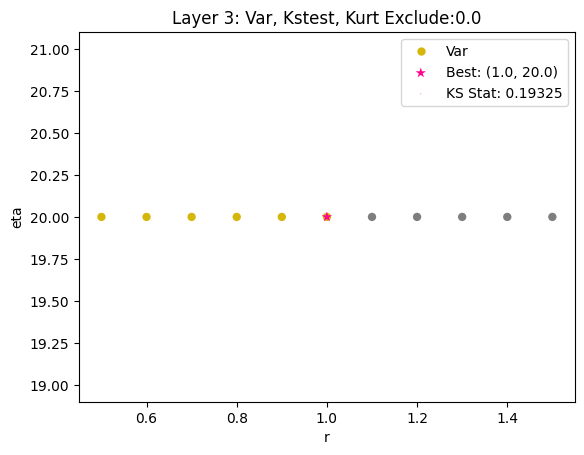

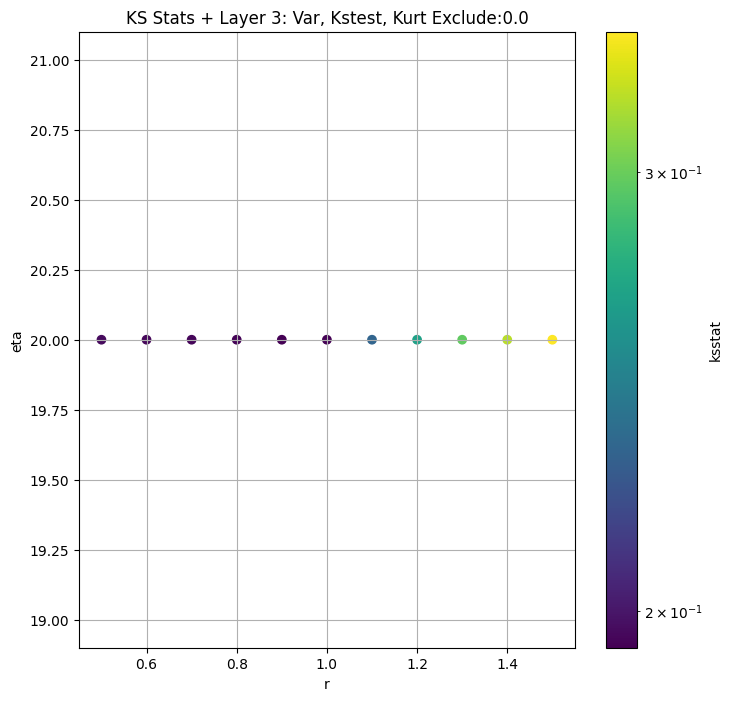

####
Layer  4


100%|██████████| 12760/12760 [00:37<00:00, 337.61it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.005233762366972497 168473.95


100%|██████████| 12760/12760 [00:37<00:00, 336.81it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.005974641377843148 166270.16


100%|██████████| 12760/12760 [00:37<00:00, 342.42it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.006570244224249497 164462.95


100%|██████████| 12760/12760 [00:37<00:00, 343.85it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.006763963986056956 162844.3


100%|██████████| 12760/12760 [00:37<00:00, 337.11it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.007291449146893225 161360.42


100%|██████████| 12760/12760 [00:40<00:00, 312.17it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.008245174938209102 158693.12


100%|██████████| 12760/12760 [00:37<00:00, 339.49it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.00910332370712294 156285.95


100%|██████████| 12760/12760 [00:40<00:00, 318.38it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.010001802833792303 154056.39


100%|██████████| 12760/12760 [00:38<00:00, 333.22it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.010694098944277253 151978.62


100%|██████████| 12760/12760 [00:38<00:00, 334.11it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.011420492683895112 150031.98


100%|██████████| 12760/12760 [00:38<00:00, 335.50it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.01351255176318722 144874.55
Number of samples: 98808, Without approximation : 98808.0


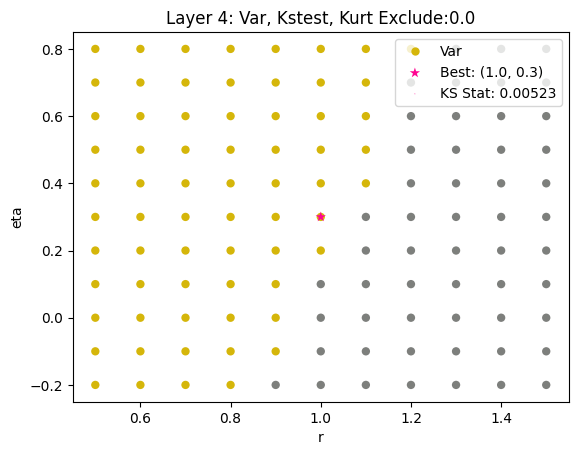

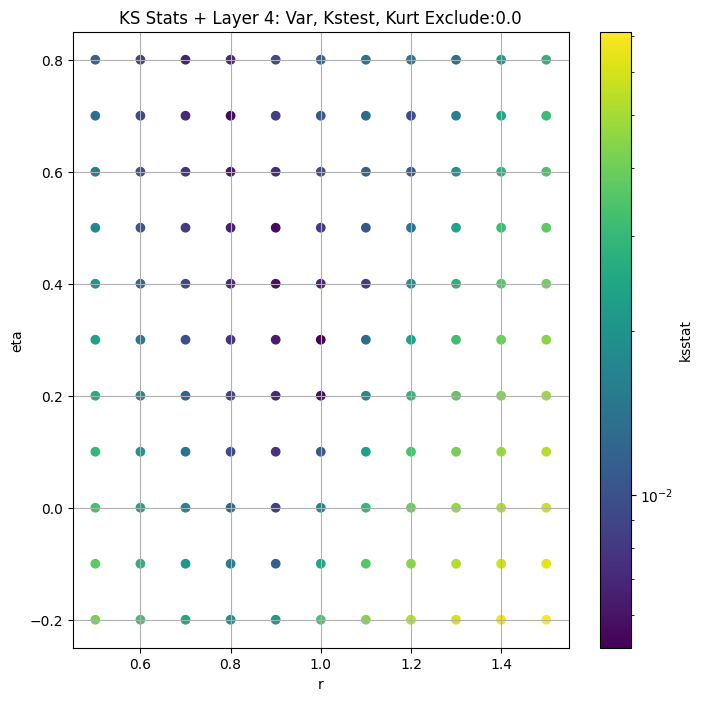

####
Layer  5


100%|██████████| 12760/12760 [00:38<00:00, 334.74it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.00414901955967234 83699.02


100%|██████████| 12760/12760 [00:37<00:00, 338.83it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.004272976093573688 82166.12


100%|██████████| 12760/12760 [00:38<00:00, 334.24it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.00495268143618071 81040.93


100%|██████████| 12760/12760 [00:38<00:00, 334.50it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.0050074499929216865 80051.58


100%|██████████| 12760/12760 [00:38<00:00, 333.46it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.005136383396430716 79144.48


100%|██████████| 12760/12760 [00:37<00:00, 336.90it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.0055764720806504575 77504.74


100%|██████████| 12760/12760 [00:36<00:00, 346.04it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.006015173917998273 76017.445


100%|██████████| 12760/12760 [01:03<00:00, 202.16it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.00658506527924152 74644.98


100%|██████████| 12760/12760 [00:41<00:00, 307.83it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.007309194904888572 73361.08


100%|██████████| 12760/12760 [00:38<00:00, 333.93it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.007894167173203903 72156.26


100%|██████████| 12760/12760 [00:37<00:00, 336.57it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.009765505651282362 68921.5
Number of samples: 100000, Without approximation : 524004.0


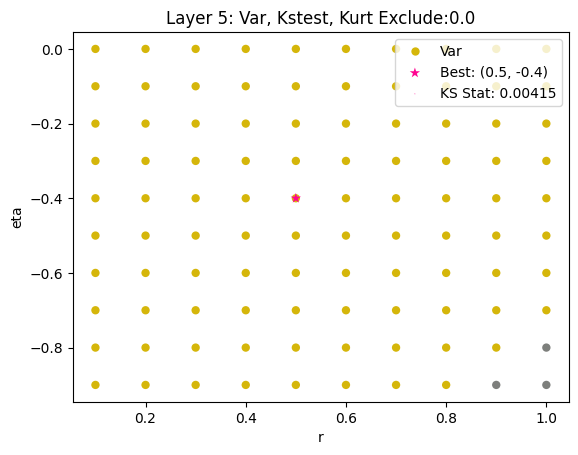

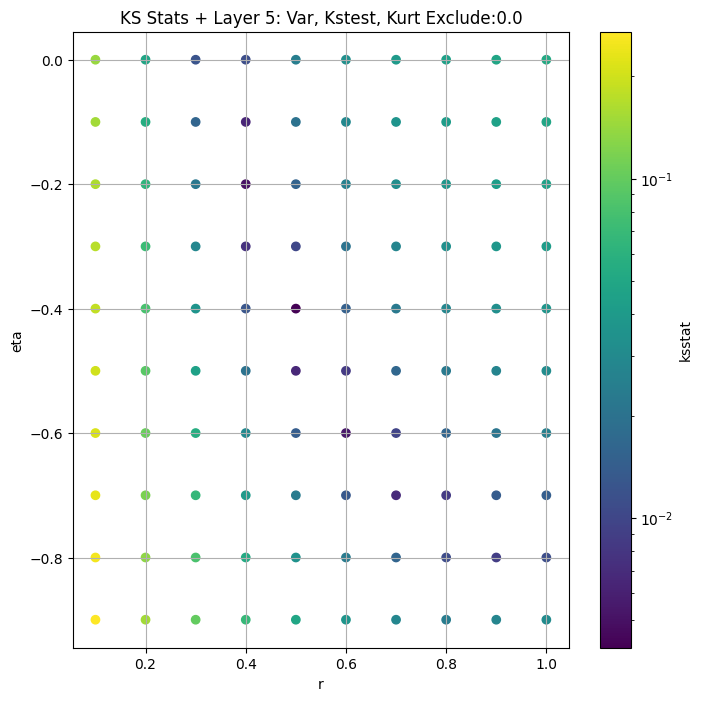

####
Layer  6


100%|██████████| 12760/12760 [00:37<00:00, 338.10it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.005828024123941122 26502.598


100%|██████████| 12760/12760 [00:37<00:00, 339.98it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.006672546723047179 25958.305


100%|██████████| 12760/12760 [00:37<00:00, 340.94it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.005720574580293958 25538.348


100%|██████████| 12760/12760 [00:37<00:00, 338.16it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.006125086796956114 25160.14


100%|██████████| 12760/12760 [00:38<00:00, 335.75it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.006654810210308226 24810.428


100%|██████████| 12760/12760 [00:37<00:00, 335.88it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.0077947301018308005 24165.943


100%|██████████| 12760/12760 [00:37<00:00, 340.17it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.008054295841726566 23579.46


100%|██████████| 12760/12760 [00:37<00:00, 338.91it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.007799965104667739 23036.578


100%|██████████| 12760/12760 [00:37<00:00, 337.88it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.008652634969790483 22529.605


100%|██████████| 12760/12760 [00:38<00:00, 334.58it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.009459207793765446 22053.531


100%|██████████| 12760/12760 [00:37<00:00, 336.44it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.0096921990669675 20773.812
Number of samples: 100000, Without approximation : 2418270.0


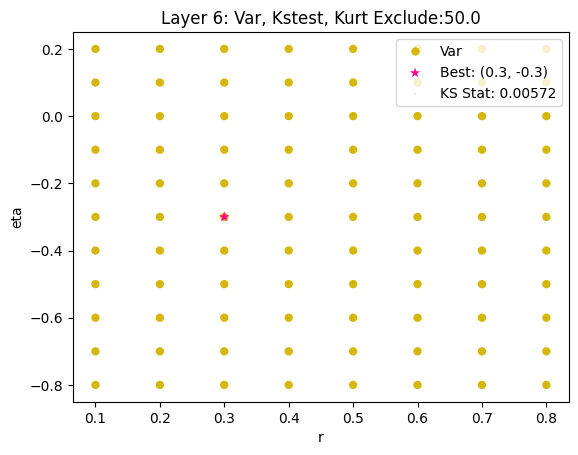

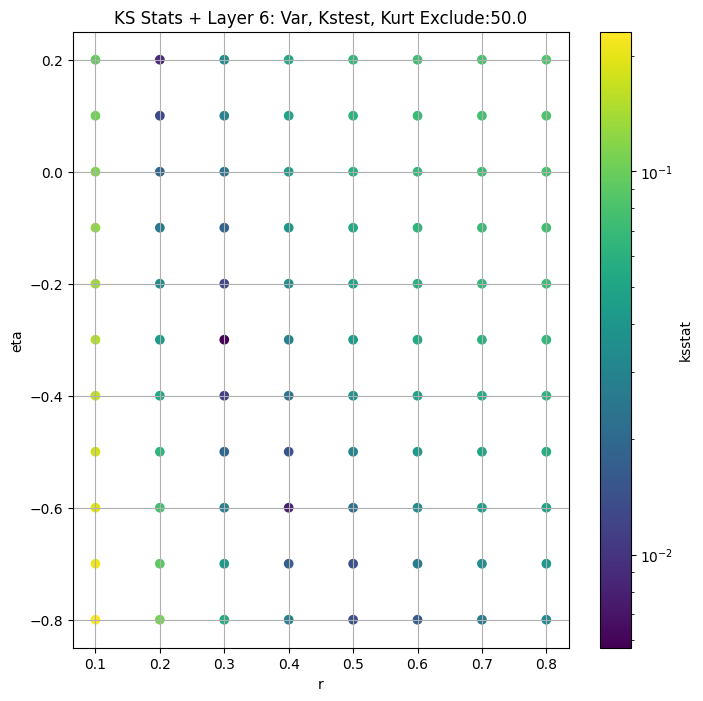

####
Layer  7


100%|██████████| 12760/12760 [00:37<00:00, 336.39it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.006486688744999136 6867.3423


100%|██████████| 12760/12760 [00:38<00:00, 335.52it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.0073859070216600875 6705.142


100%|██████████| 12760/12760 [00:37<00:00, 338.51it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.006615303486682711 6576.92


100%|██████████| 12760/12760 [00:37<00:00, 338.09it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.00686247901685344 6463.1304


100%|██████████| 12760/12760 [00:37<00:00, 339.94it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.007307404724511191 6358.668


100%|██████████| 12760/12760 [00:37<00:00, 336.80it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.006978623363219194 6168.5522


100%|██████████| 12760/12760 [00:38<00:00, 331.08it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.007804787886713793 5996.6045


100%|██████████| 12760/12760 [00:37<00:00, 339.48it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.008569624596559633 5838.1313


100%|██████████| 12760/12760 [00:37<00:00, 336.06it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.008445047708185771 5690.633


100%|██████████| 12760/12760 [00:38<00:00, 333.54it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.009232931098304142 5552.2715


100%|██████████| 12760/12760 [00:37<00:00, 344.22it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.010221863023892608 5180.713
Number of samples: 100000, Without approximation : 10234344.0


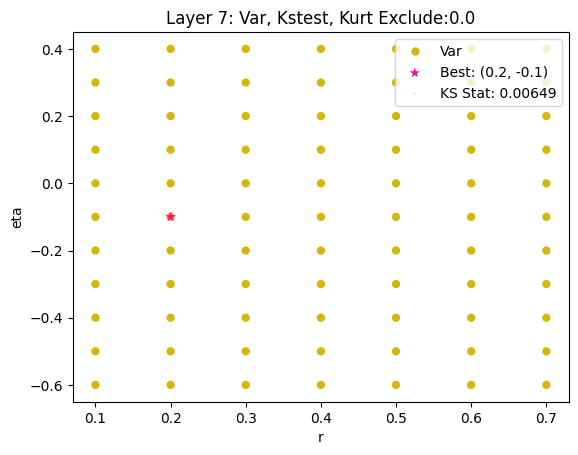

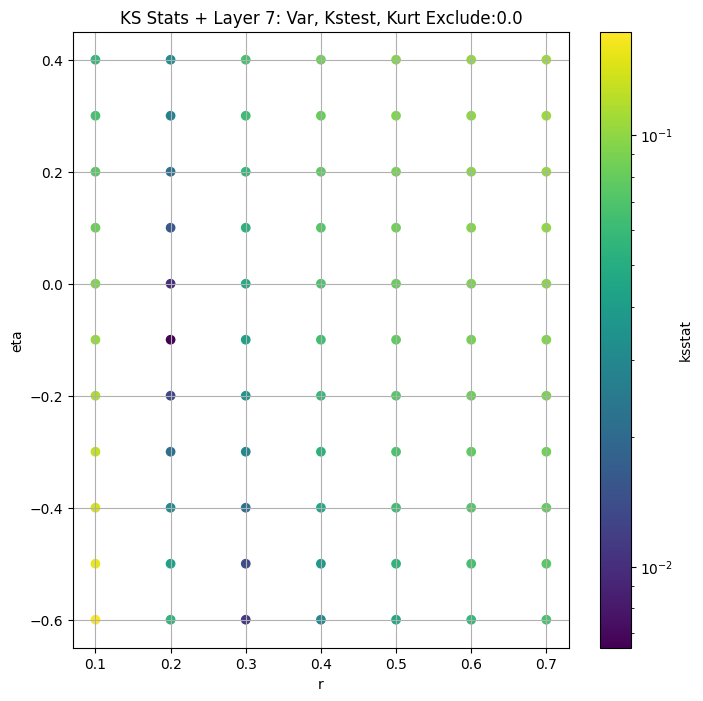

####
Layer  8


100%|██████████| 12760/12760 [00:36<00:00, 345.30it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.007924962118539734 977.00665


100%|██████████| 12760/12760 [00:37<00:00, 341.45it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.007030201508612999 947.782


100%|██████████| 12760/12760 [00:37<00:00, 342.36it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.007546805854594274 926.4807


100%|██████████| 12760/12760 [00:37<00:00, 342.78it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.00813049648868364 908.214


100%|██████████| 12760/12760 [00:36<00:00, 345.28it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.008656527961318217 891.8961


100%|██████████| 12760/12760 [00:36<00:00, 346.62it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.009141720075640496 863.0156


100%|██████████| 12760/12760 [00:37<00:00, 343.93it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.00870869217986825 837.49493


100%|██████████| 12760/12760 [00:37<00:00, 342.13it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.009497180290120383 814.37384


100%|██████████| 12760/12760 [00:37<00:00, 342.93it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.01027300184532192 793.12604


100%|██████████| 12760/12760 [00:36<00:00, 345.36it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.009951586927577305 773.4123


100%|██████████| 12760/12760 [00:35<00:00, 356.56it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.01126328501440984 721.4084
Number of samples: 100000, Without approximation : 42110360.0


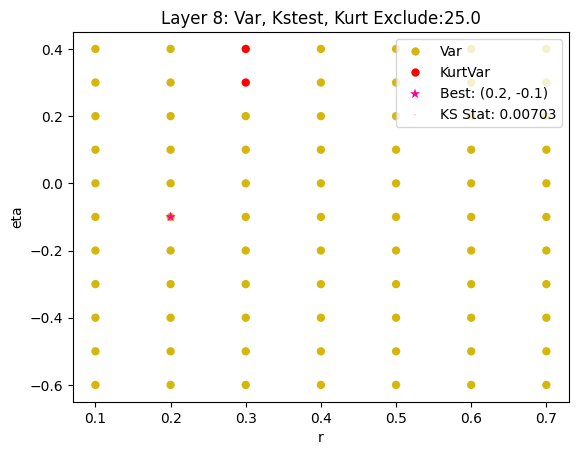

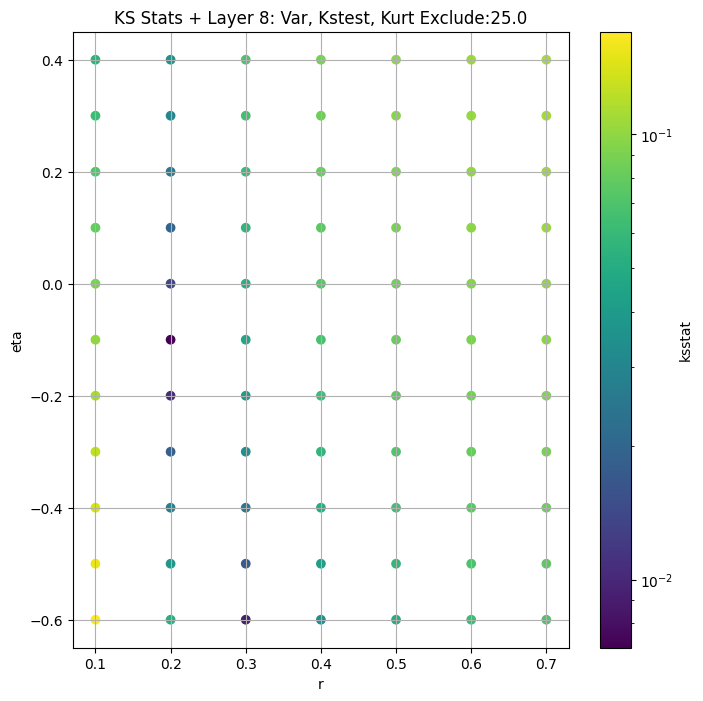

####
Layer  9


100%|██████████| 12760/12760 [00:36<00:00, 347.06it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.0054065714141167814 94.96691


100%|██████████| 12760/12760 [00:36<00:00, 345.41it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.005711318624211037 89.417946


100%|██████████| 12760/12760 [00:37<00:00, 343.54it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.007214772087069221 86.51905


100%|██████████| 12760/12760 [00:37<00:00, 344.53it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.006513166818617022 84.20633


100%|██████████| 12760/12760 [00:36<00:00, 345.39it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.006735534790862328 82.231766


100%|██████████| 12760/12760 [00:37<00:00, 343.13it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.007743201526579924 78.90299


100%|██████████| 12760/12760 [00:36<00:00, 347.16it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.008592060460153768 76.098404


100%|██████████| 12760/12760 [00:36<00:00, 349.04it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.008097918409344818 73.646614


100%|██████████| 12760/12760 [00:36<00:00, 347.65it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.0090293023664825 71.4558


100%|██████████| 12760/12760 [00:36<00:00, 354.20it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.009186177661082956 69.46959


100%|██████████| 12760/12760 [00:34<00:00, 366.47it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.010166594329764522 64.38837
Number of samples: 100000, Without approximation : 170911996.0


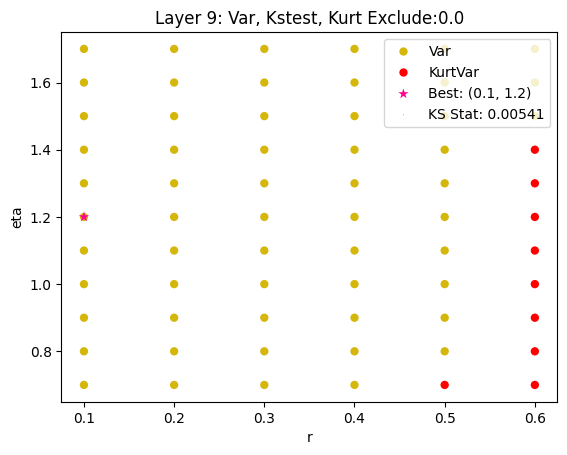

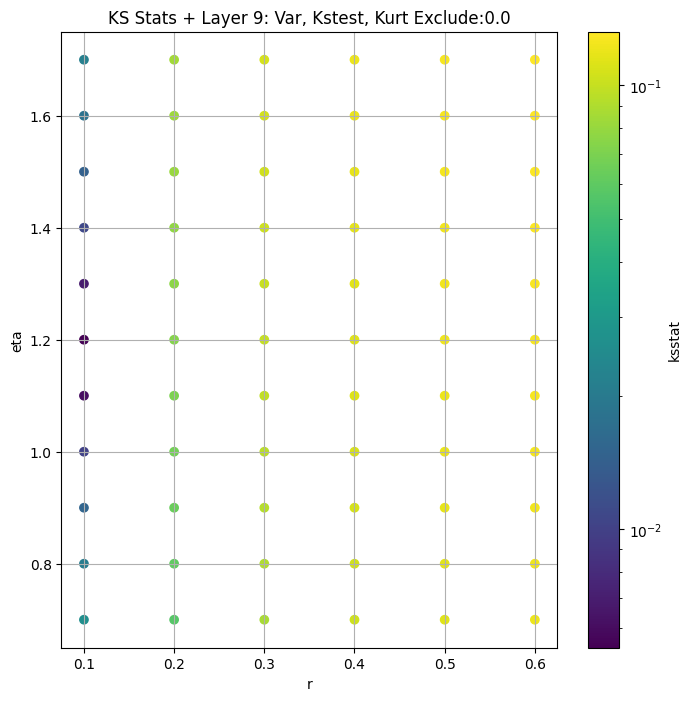

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.136796e+06,2.089662e+06,2.183364e+06,-1.757529,-1.772466,-1.739543,3396.0,0.193246,1.0,20.0,9.938585e+04,0.0,2.136796e+06,0.023255
4,1.684740e+05,1.600476e+05,1.771482e+05,1.874441,1.463638,2.318799,98808.0,0.005234,1.0,0.3,9.359664e+04,0.0,1.684740e+05,0.004319
5,8.369902e+04,7.840057e+04,8.918237e+04,4.219650,3.506101,5.112777,524004.0,0.004149,0.5,-0.4,1.188907e+04,0.0,8.369902e+04,0.001876
6,2.650260e+04,2.454781e+04,2.854205e+04,6.584359,5.694902,7.737797,2418270.0,0.005721,0.3,-0.3,1.130460e+02,50.0,2.553835e+04,0.000873
7,6.867342e+03,6.302964e+03,7.459079e+03,8.624499,7.535332,9.846775,10234344.0,0.006487,0.2,-0.1,1.238698e-01,0.0,6.867342e+03,0.000425
8,9.770067e+02,8.924991e+02,1.067059e+03,9.898498,8.096569,13.575704,42110360.0,0.007030,0.2,-0.1,1.709563e-02,25.0,9.477820e+02,0.000209
9,9.496691e+01,8.462709e+01,1.075309e+02,19.474989,11.005217,47.744520,170911996.0,0.005407,0.1,1.2,1.029571e-13,0.0,9.496691e+01,0.000104


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


100%|██████████| 99/99 [00:00<00:00, 5488.77it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.20081264440073932, var: 1985217.5


100%|██████████| 99/99 [00:00<00:00, 6955.26it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.19919752815123476, var: 2016164.25


100%|██████████| 99/99 [00:00<00:00, 7282.16it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.19745845253472766, var: 2050182.25


100%|██████████| 99/99 [00:00<00:00, 7325.71it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.19558395422572566, var: 2088469.75


100%|██████████| 99/99 [00:00<00:00, 7196.47it/s]

Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.19324628442281971, var: 2136795.75
Number of samples: 3396, Without approximation : 3396.0


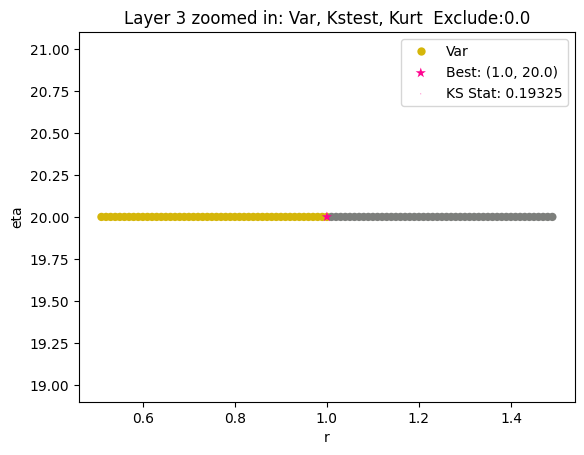

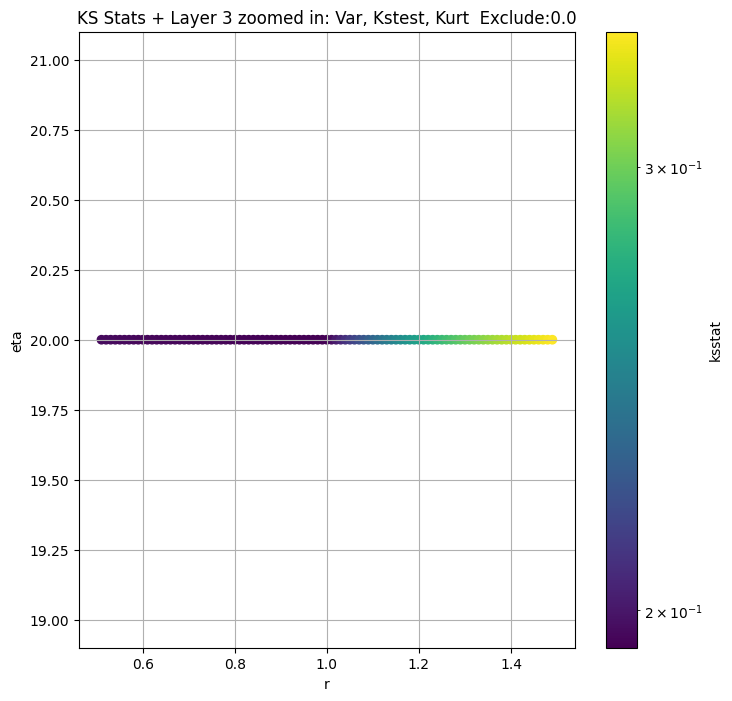

Layer 4


100%|██████████| 1053/1053 [00:03<00:00, 347.26it/s]


Finding Minimum after computing 1053 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.007291449146893225, var: 161360.421875


100%|██████████| 1053/1053 [00:02<00:00, 373.05it/s]


Finding Minimum after computing 1053 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.006763963986056956, var: 162844.296875


100%|██████████| 1053/1053 [00:02<00:00, 373.16it/s]


Finding Minimum after computing 1053 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.006343758876359004, var: 164462.953125


100%|██████████| 1053/1053 [00:02<00:00, 371.13it/s]


Finding Minimum after computing 1053 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.005828471274159766, var: 166270.15625


100%|██████████| 1053/1053 [00:02<00:00, 372.94it/s]


Finding Minimum after computing 1053 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.005233762366972497, var: 168473.953125
Number of samples: 98808, Without approximation : 98808.0


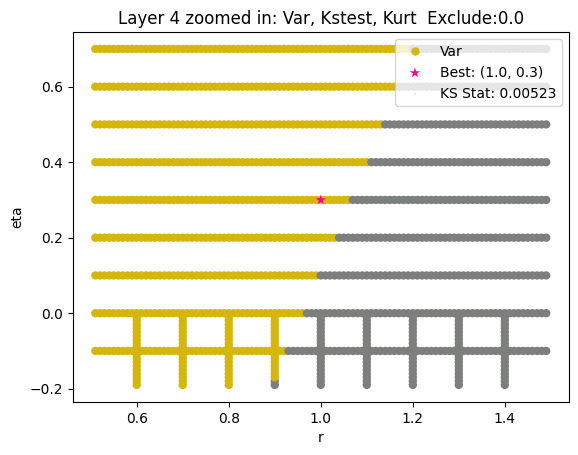

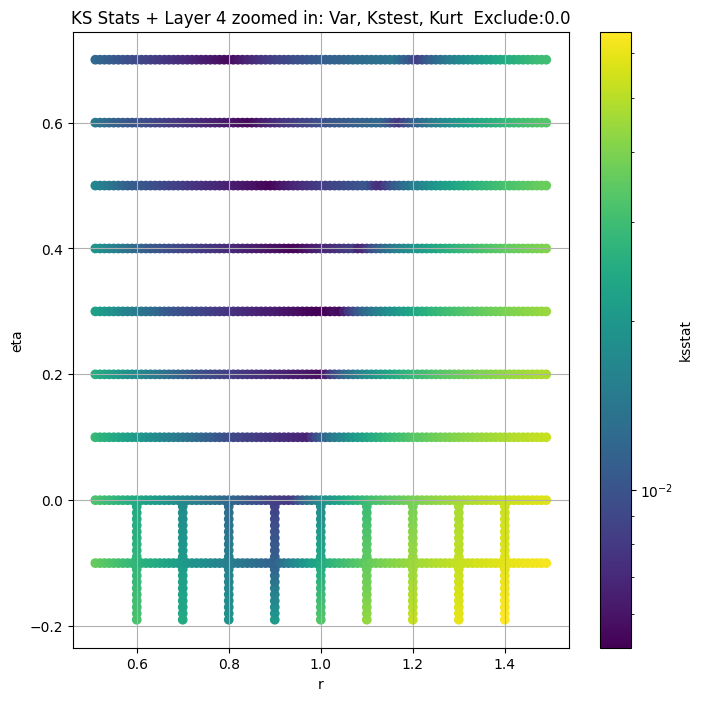

Layer 5


100%|██████████| 1611/1611 [00:04<00:00, 353.45it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.004703016024739437, var: 79144.4765625


100%|██████████| 1611/1611 [00:04<00:00, 367.74it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.004229393027039063, var: 80051.578125


100%|██████████| 1611/1611 [00:04<00:00, 365.29it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.004041497464307375, var: 81040.9296875


100%|██████████| 1611/1611 [00:04<00:00, 367.16it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.003597971723913851, var: 82166.1171875


100%|██████████| 1611/1611 [00:04<00:00, 365.75it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0033432752560523804, var: 83699.0234375
Number of samples: 100000, Without approximation : 524004.0


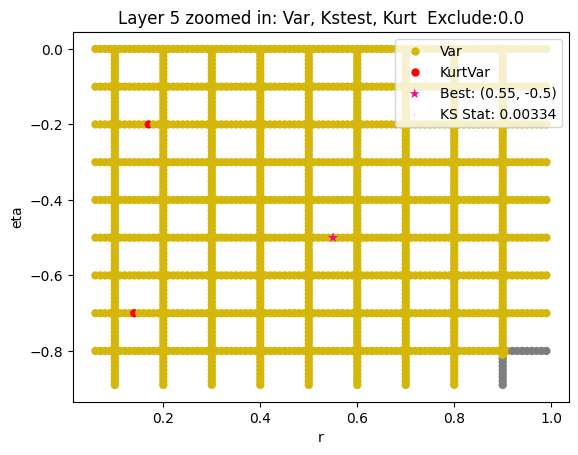

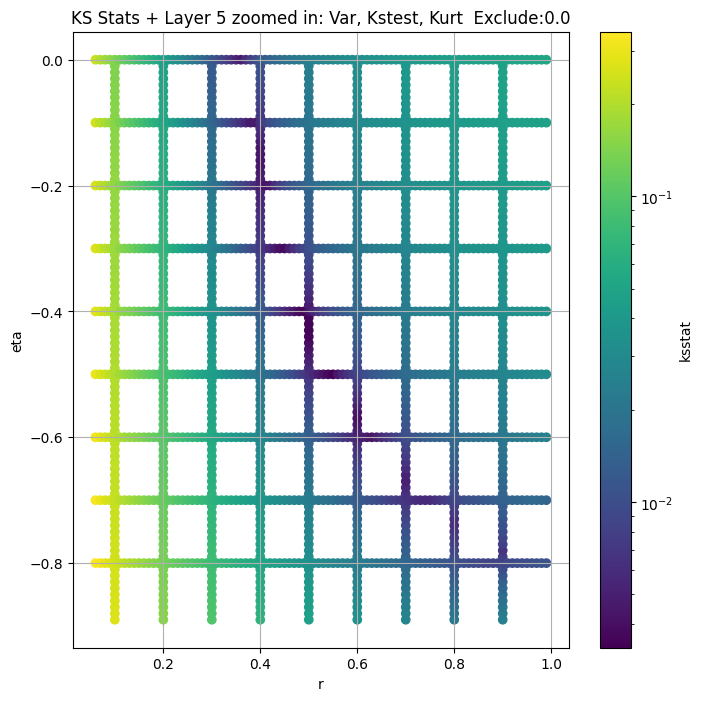

Layer 6


100%|██████████| 1206/1206 [00:03<00:00, 364.20it/s]


Finding Minimum after computing 1206 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.006653177141643152, var: 24165.943359375


100%|██████████| 1206/1206 [00:03<00:00, 350.48it/s]


Finding Minimum after computing 1206 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.006423402151758302, var: 24480.142578125


100%|██████████| 1206/1206 [00:03<00:00, 366.12it/s]


Finding Minimum after computing 1206 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.006219951165815141, var: 24810.427734375


100%|██████████| 1206/1206 [00:03<00:00, 367.06it/s]


Finding Minimum after computing 1206 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.005735192737400974, var: 25160.140625


100%|██████████| 1206/1206 [00:03<00:00, 359.74it/s]


Finding Minimum after computing 1206 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.00561801287726571, var: 25538.34765625


100%|██████████| 1206/1206 [00:03<00:00, 367.80it/s]


Finding Minimum after computing 1206 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.005561895205054457, var: 25958.3046875


100%|██████████| 1206/1206 [00:03<00:00, 368.06it/s]


Finding Minimum after computing 1206 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.005114544607014243, var: 26502.59765625
Number of samples: 100000, Without approximation : 2418270.0


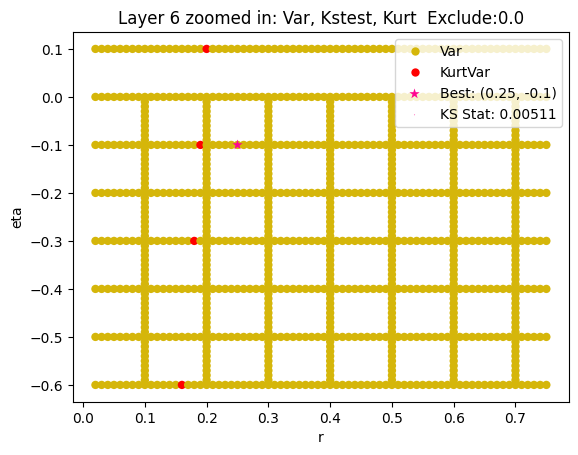

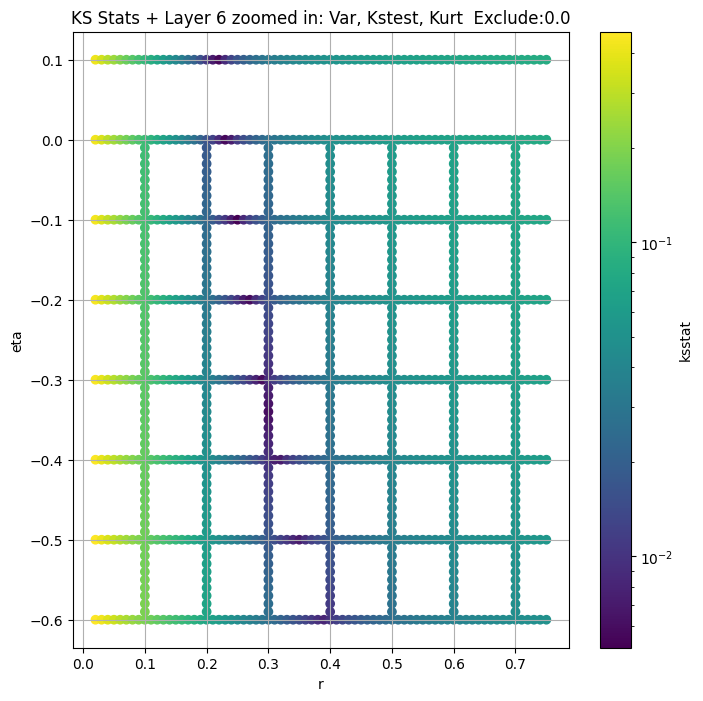

Layer 7


100%|██████████| 999/999 [00:02<00:00, 356.28it/s]


Finding Minimum after computing 999 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.006495999188847135, var: 6358.66796875


100%|██████████| 999/999 [00:02<00:00, 363.37it/s]


Finding Minimum after computing 999 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.006504434818333349, var: 6463.13037109375


100%|██████████| 999/999 [00:02<00:00, 367.88it/s]


Finding Minimum after computing 999 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.006296244490874514, var: 6576.919921875


100%|██████████| 999/999 [00:02<00:00, 365.92it/s]


Finding Minimum after computing 999 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.005874364408028965, var: 6705.14208984375


100%|██████████| 999/999 [00:02<00:00, 367.78it/s]


Finding Minimum after computing 999 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.005481346057144232, var: 6867.34228515625
Number of samples: 100000, Without approximation : 10234344.0


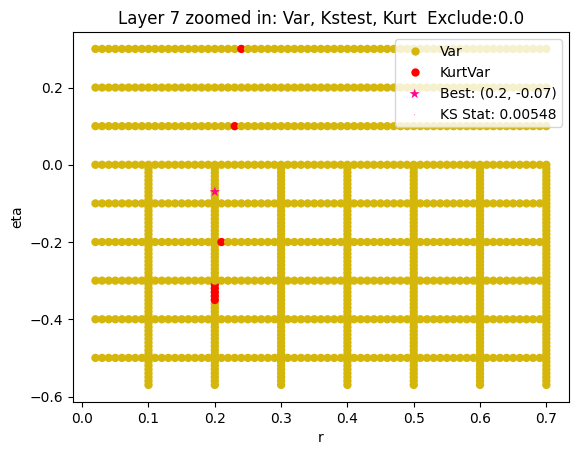

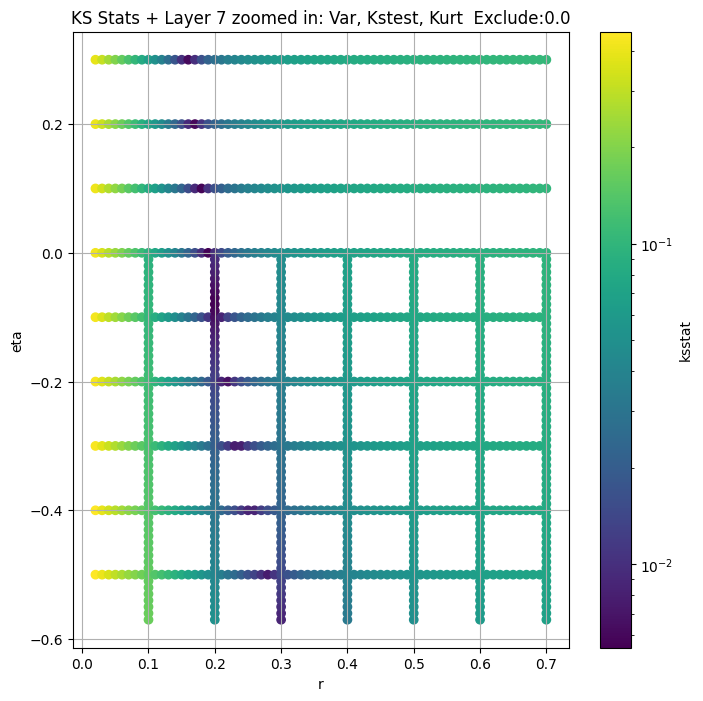

Layer 8


100%|██████████| 999/999 [00:02<00:00, 366.11it/s]


Finding Minimum after computing 999 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.007613647180364409, var: 876.9417724609375


100%|██████████| 999/999 [00:02<00:00, 365.79it/s]


Finding Minimum after computing 999 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.007597117268290043, var: 891.8961181640625


100%|██████████| 999/999 [00:02<00:00, 367.04it/s]


Finding Minimum after computing 999 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.0076441900754857794, var: 908.2139892578125


100%|██████████| 999/999 [00:02<00:00, 367.90it/s]


Finding Minimum after computing 999 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.007142499241216547, var: 926.480712890625


100%|██████████| 999/999 [00:02<00:00, 365.43it/s]


Finding Minimum after computing 999 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.006897183378705818, var: 947.781982421875


100%|██████████| 999/999 [00:02<00:00, 367.81it/s]


Finding Minimum after computing 999 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.006298488699404081, var: 977.0066528320312
Number of samples: 100000, Without approximation : 42110360.0


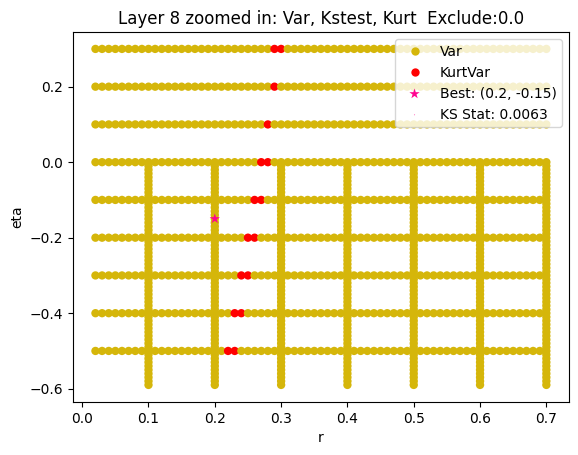

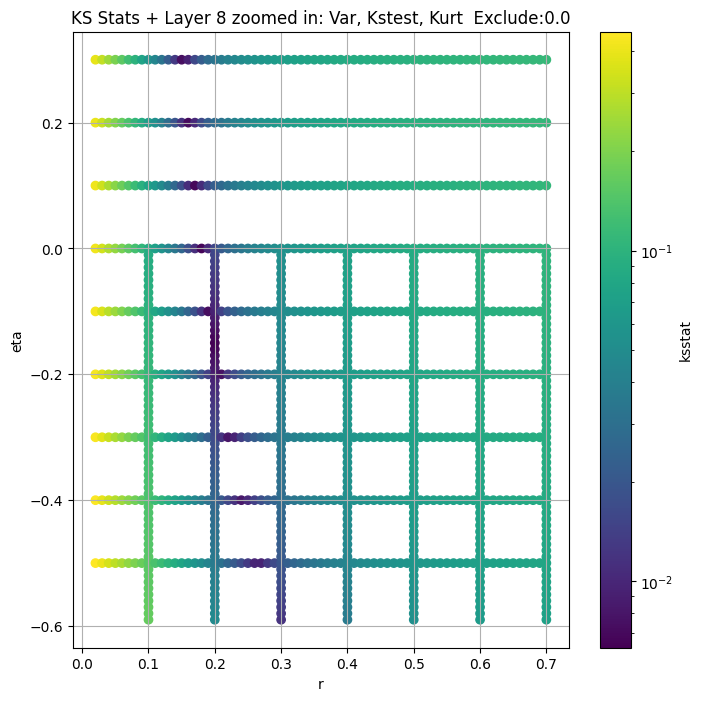

Layer 9


100%|██████████| 522/522 [00:01<00:00, 341.12it/s]


Finding Minimum after computing 522 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.0077114597728236076, var: 82.23176574707031


100%|██████████| 522/522 [00:01<00:00, 355.65it/s]


Finding Minimum after computing 522 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.00719680245643009, var: 84.20632934570312


100%|██████████| 522/522 [00:01<00:00, 360.70it/s]


Finding Minimum after computing 522 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.006811521583073632, var: 86.51905059814453


100%|██████████| 522/522 [00:01<00:00, 352.70it/s]


Finding Minimum after computing 522 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.006144658151190689, var: 89.4179458618164


100%|██████████| 522/522 [00:01<00:00, 367.40it/s]


Finding Minimum after computing 522 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.005400129454305187, var: 94.96691131591797
Number of samples: 100000, Without approximation : 170911996.0


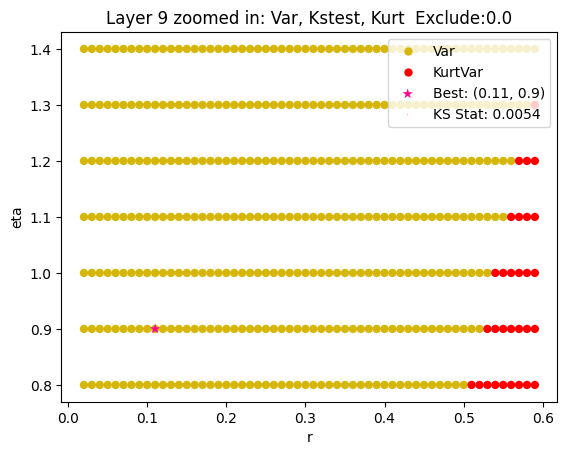

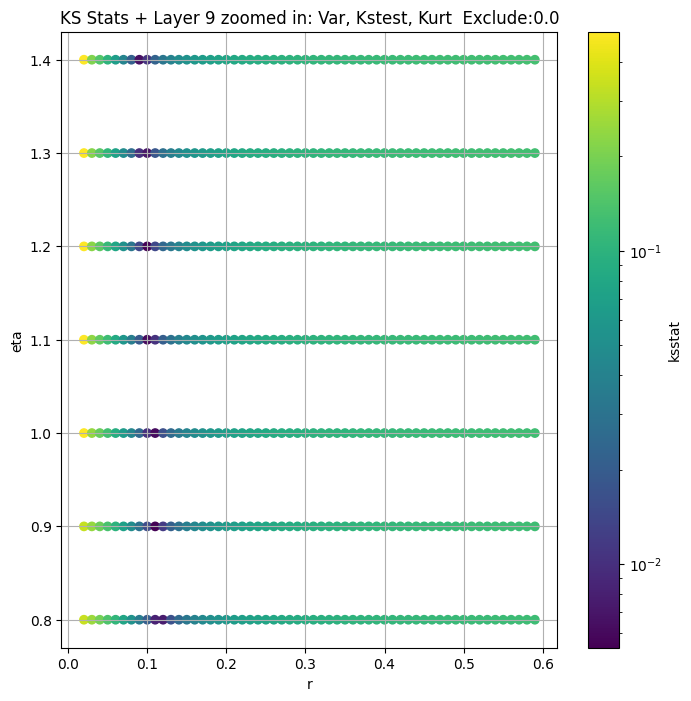

Cannot compute pval with ksstat : nan, n : 0.0


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,2.136796e+06,2.089662e+06,2.183364e+06,-1.757529,-1.772466,-1.739543,3396.0,0.193246,1.0,20.0,9.938585e+04,0.0,2.136796e+06,0.023255,0.193246,1.00,20.00,9.938585e+04,0.0,48
4,1.684740e+05,1.600476e+05,1.771482e+05,1.874441,1.463638,2.318799,98808.0,0.005234,1.0,0.3,9.359664e+04,0.0,1.684740e+05,0.004319,0.005234,1.00,0.30,9.359664e+04,0.0,70341
5,8.369902e+04,7.840057e+04,8.918237e+04,4.219650,3.506101,5.112777,524004.0,0.004149,0.5,-0.4,1.188907e+04,0.0,8.369902e+04,0.001876,0.003343,0.55,-0.50,2.022694e+04,0.0,165796
6,2.650260e+04,2.454781e+04,2.854205e+04,6.584359,5.694902,7.737797,2418270.0,0.005721,0.3,-0.3,1.130460e+02,50.0,2.650260e+04,0.000873,0.005115,0.25,-0.10,1.097096e+01,0.0,71730
7,6.867342e+03,6.302964e+03,7.459079e+03,8.624499,7.535332,9.846775,10234344.0,0.006487,0.2,-0.1,1.238698e-01,0.0,6.867342e+03,0.000425,0.005481,0.20,-0.07,1.138054e-01,0.0,59965
8,9.770067e+02,8.924991e+02,1.067059e+03,9.898498,8.096569,13.575704,42110360.0,0.007030,0.2,-0.1,1.709563e-02,25.0,9.770067e+02,0.000209,0.006298,0.20,-0.15,2.036437e-02,0.0,46263
9,9.496691e+01,8.462709e+01,1.075309e+02,19.474989,11.005217,47.744520,170911996.0,0.005407,0.1,1.2,1.029571e-13,0.0,9.496691e+01,0.000104,0.005400,0.11,0.90,1.429557e-11,0.0,62589


In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

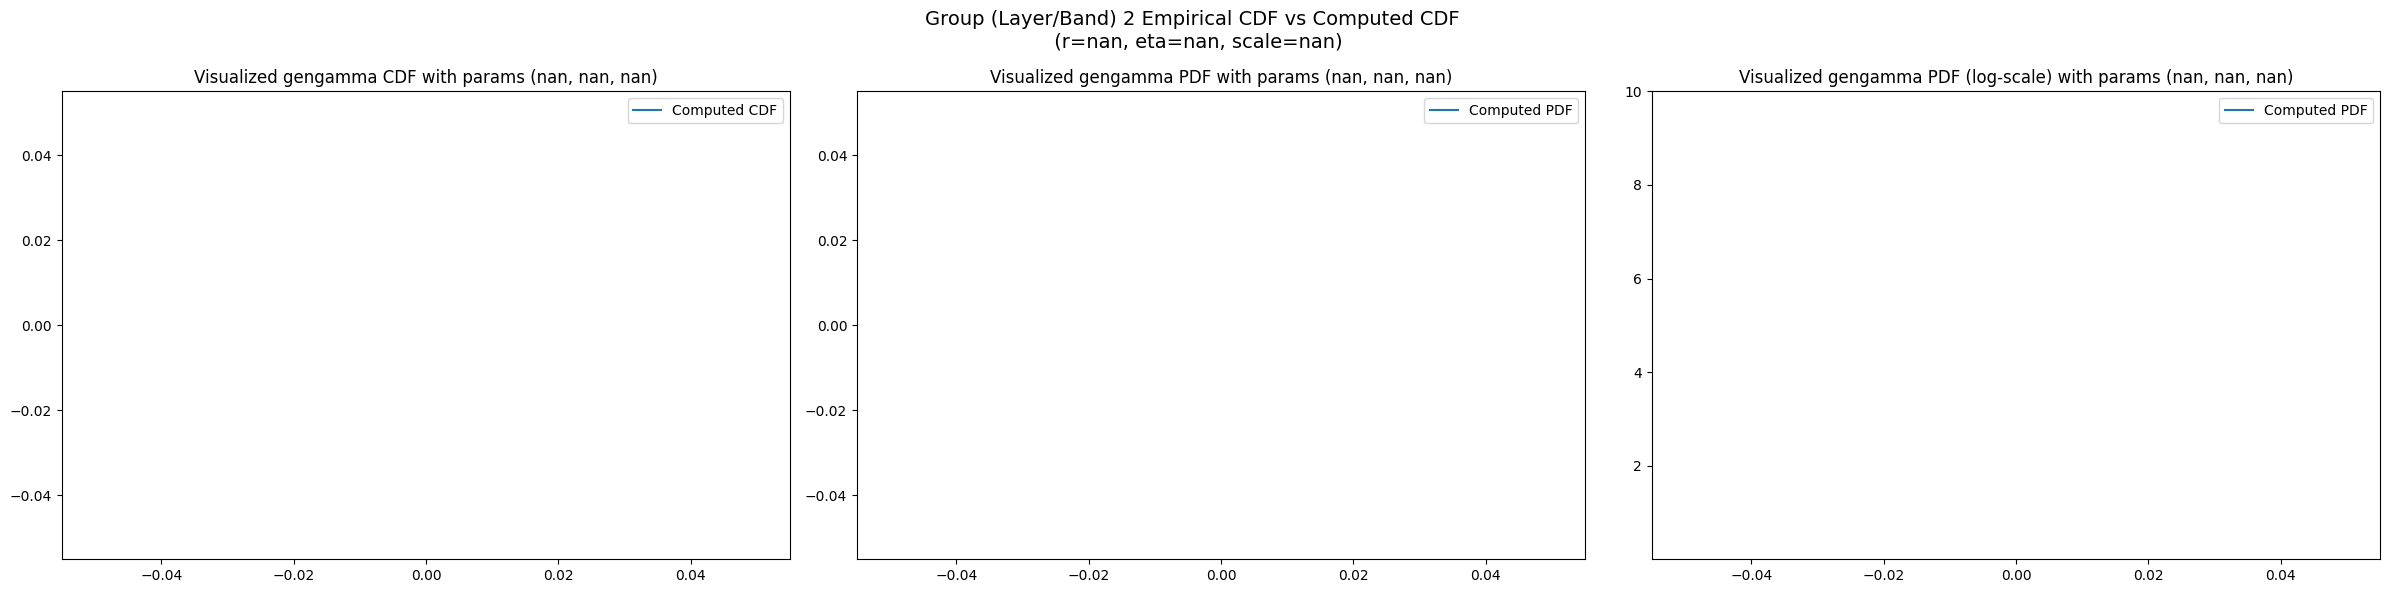

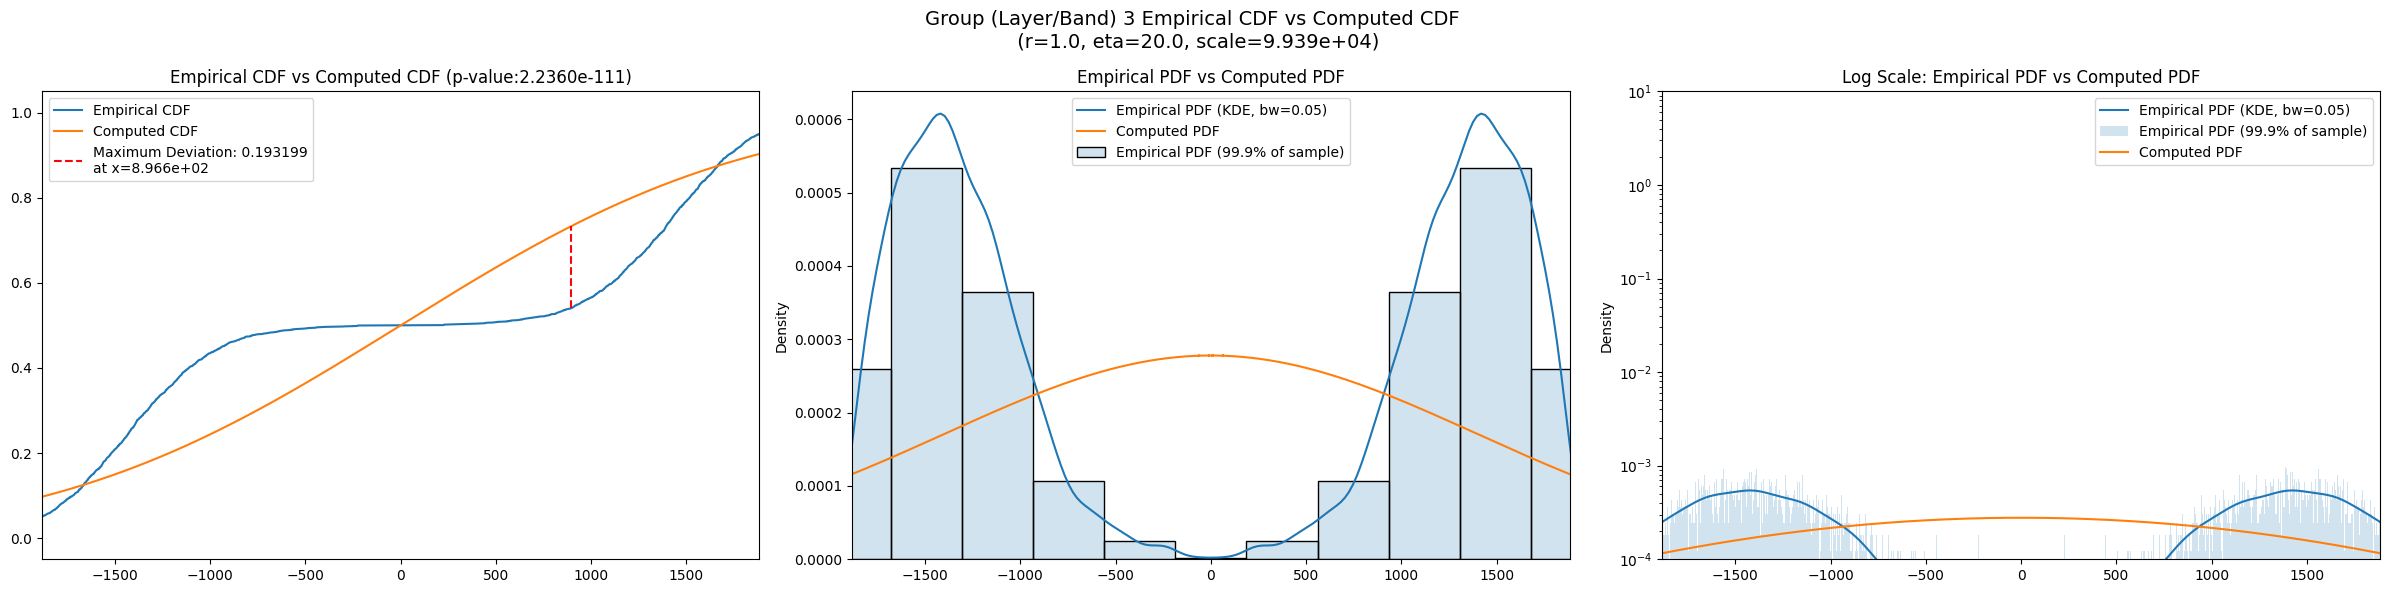

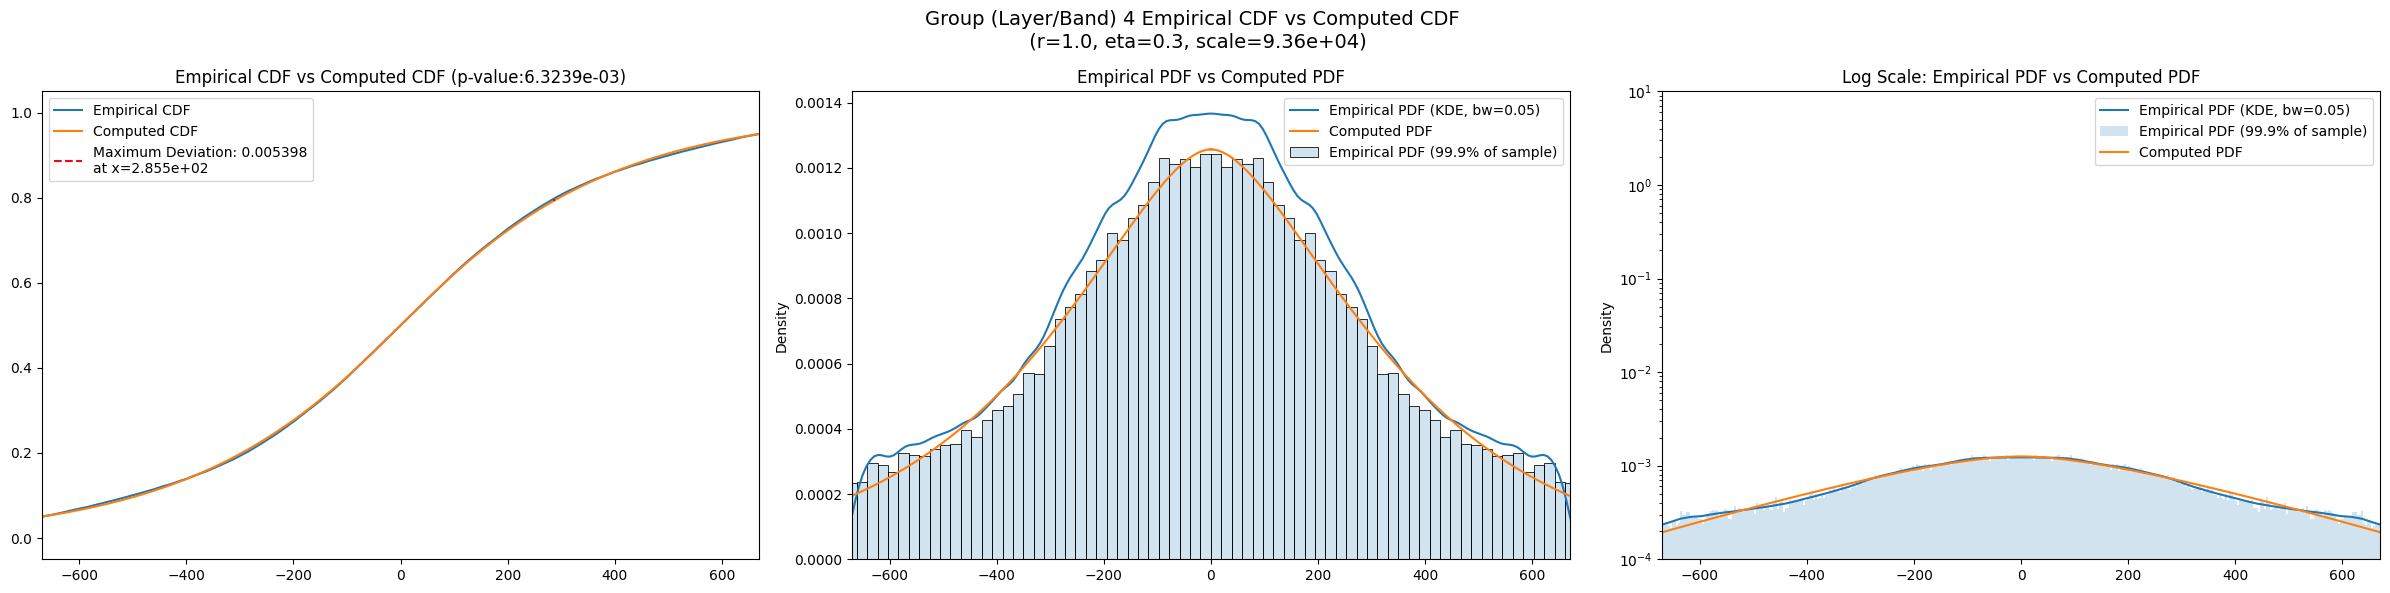

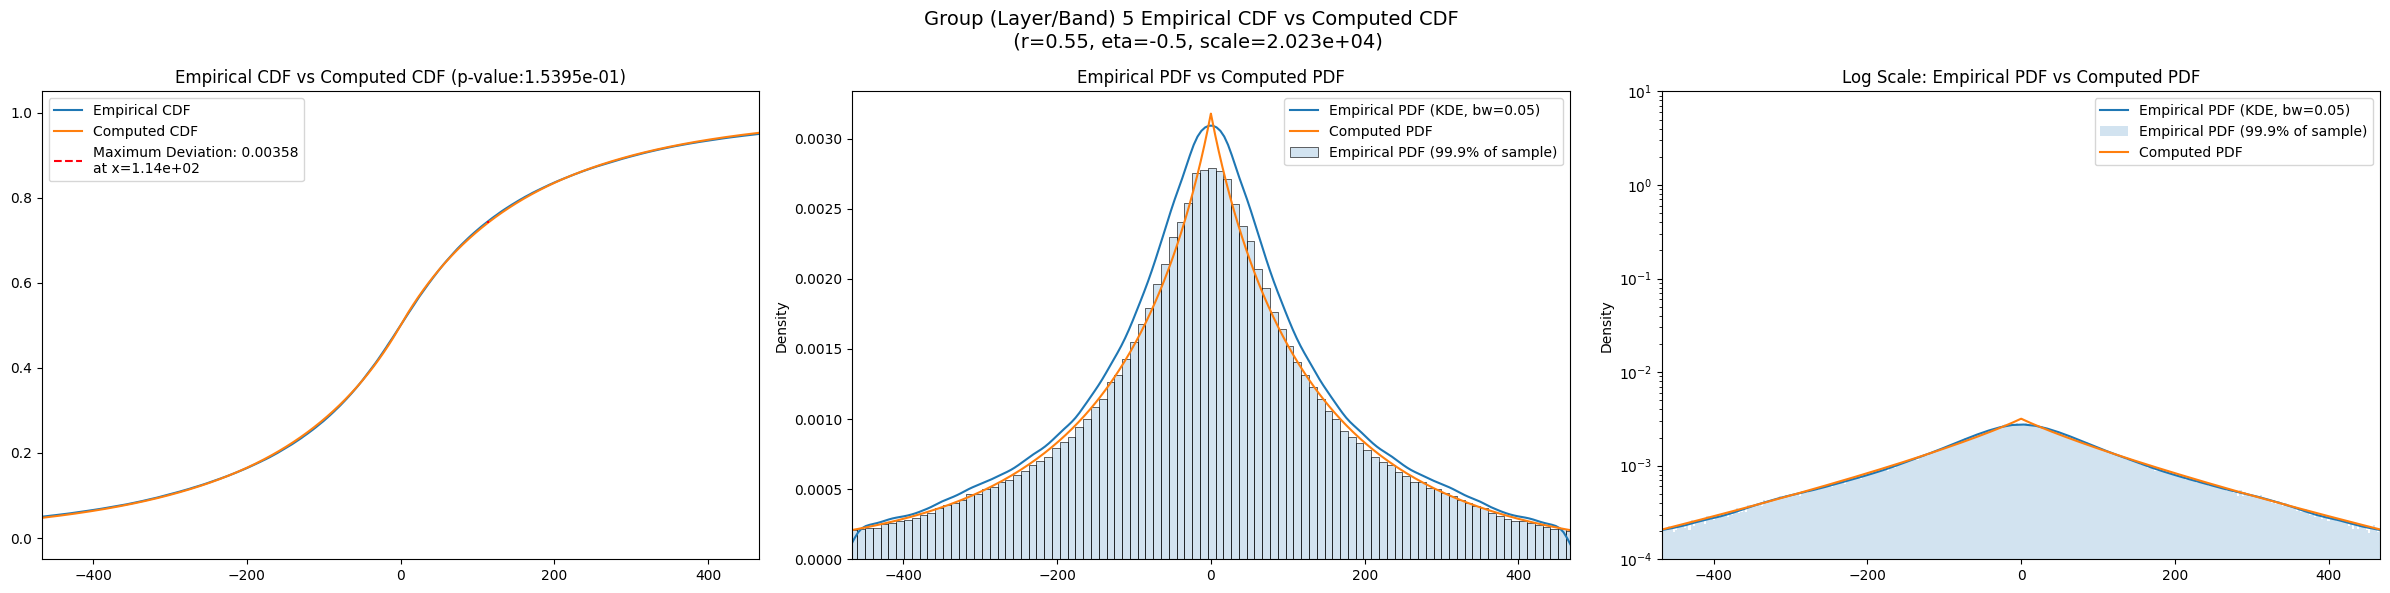

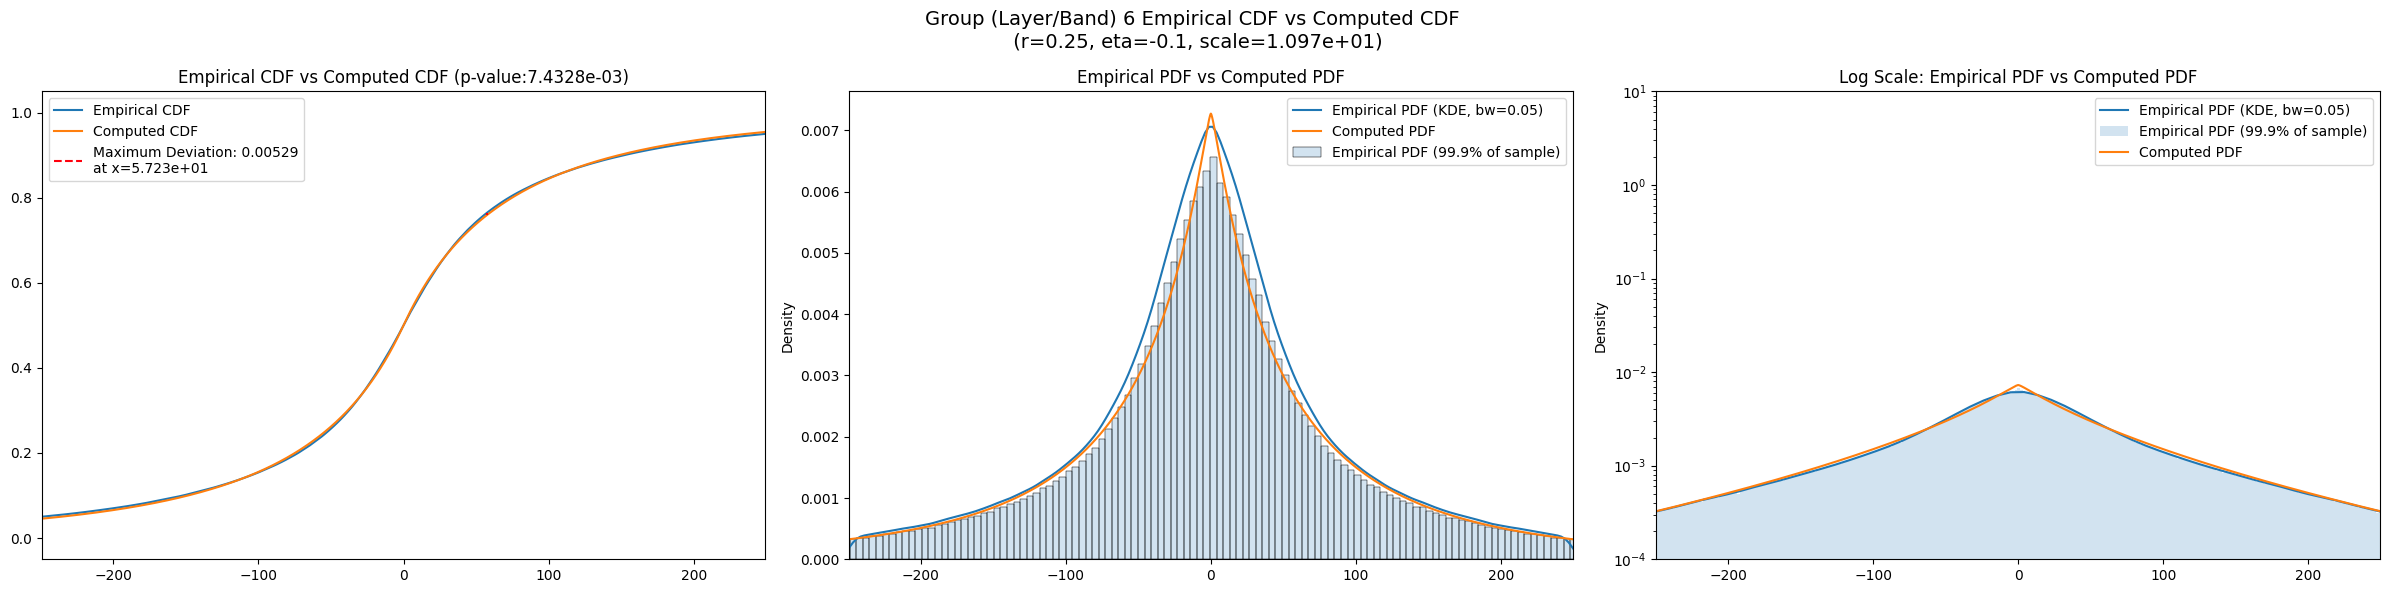

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:454: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


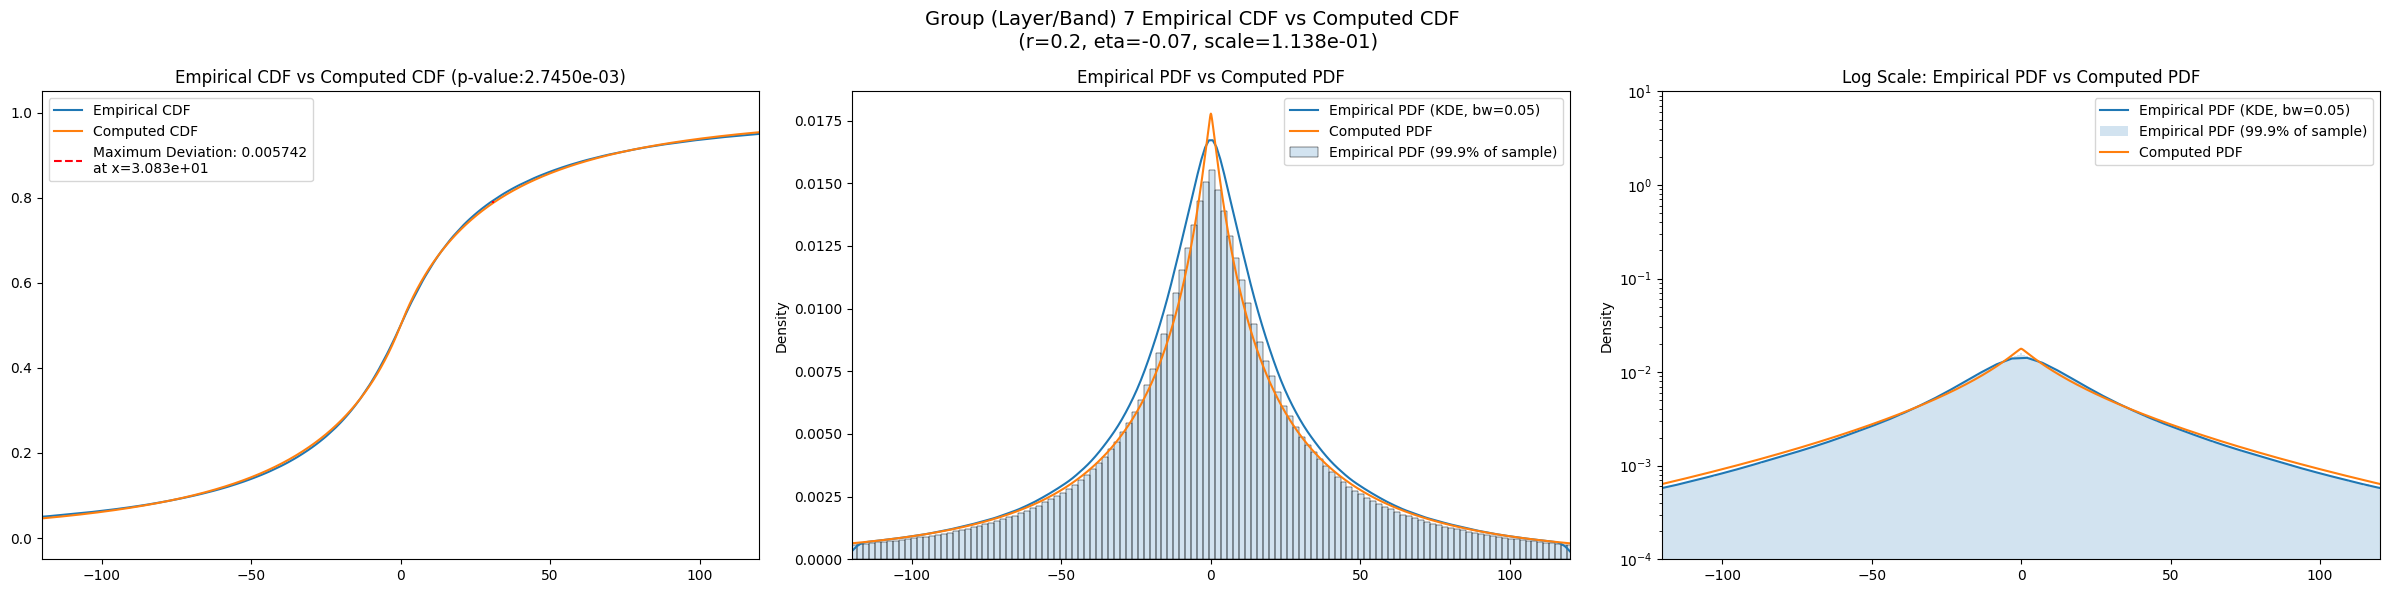

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_43876/82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


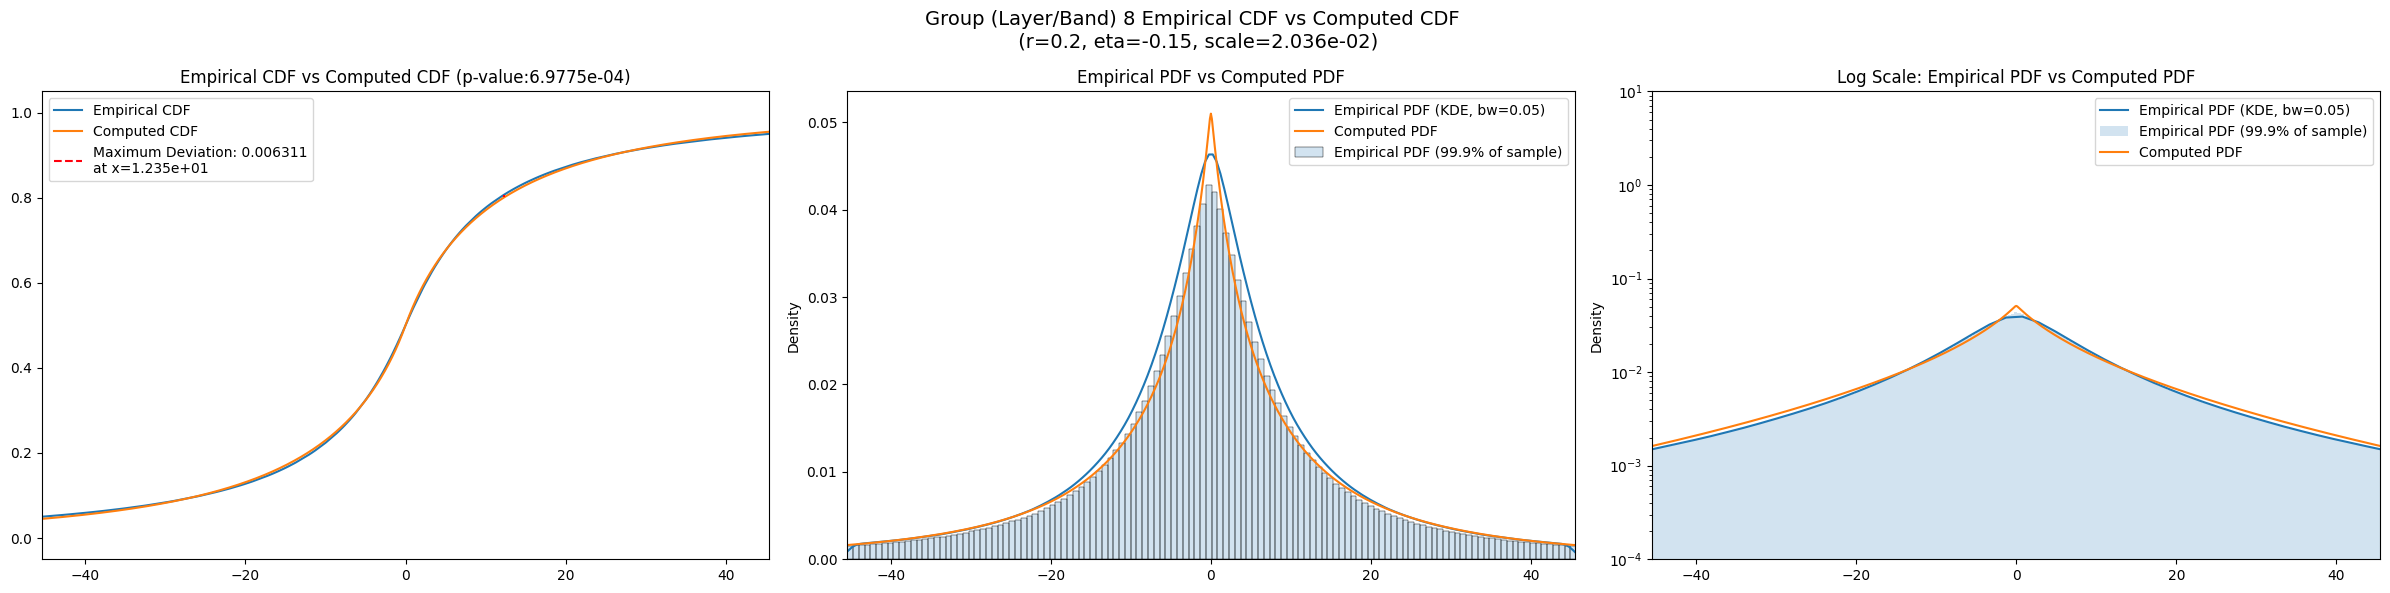

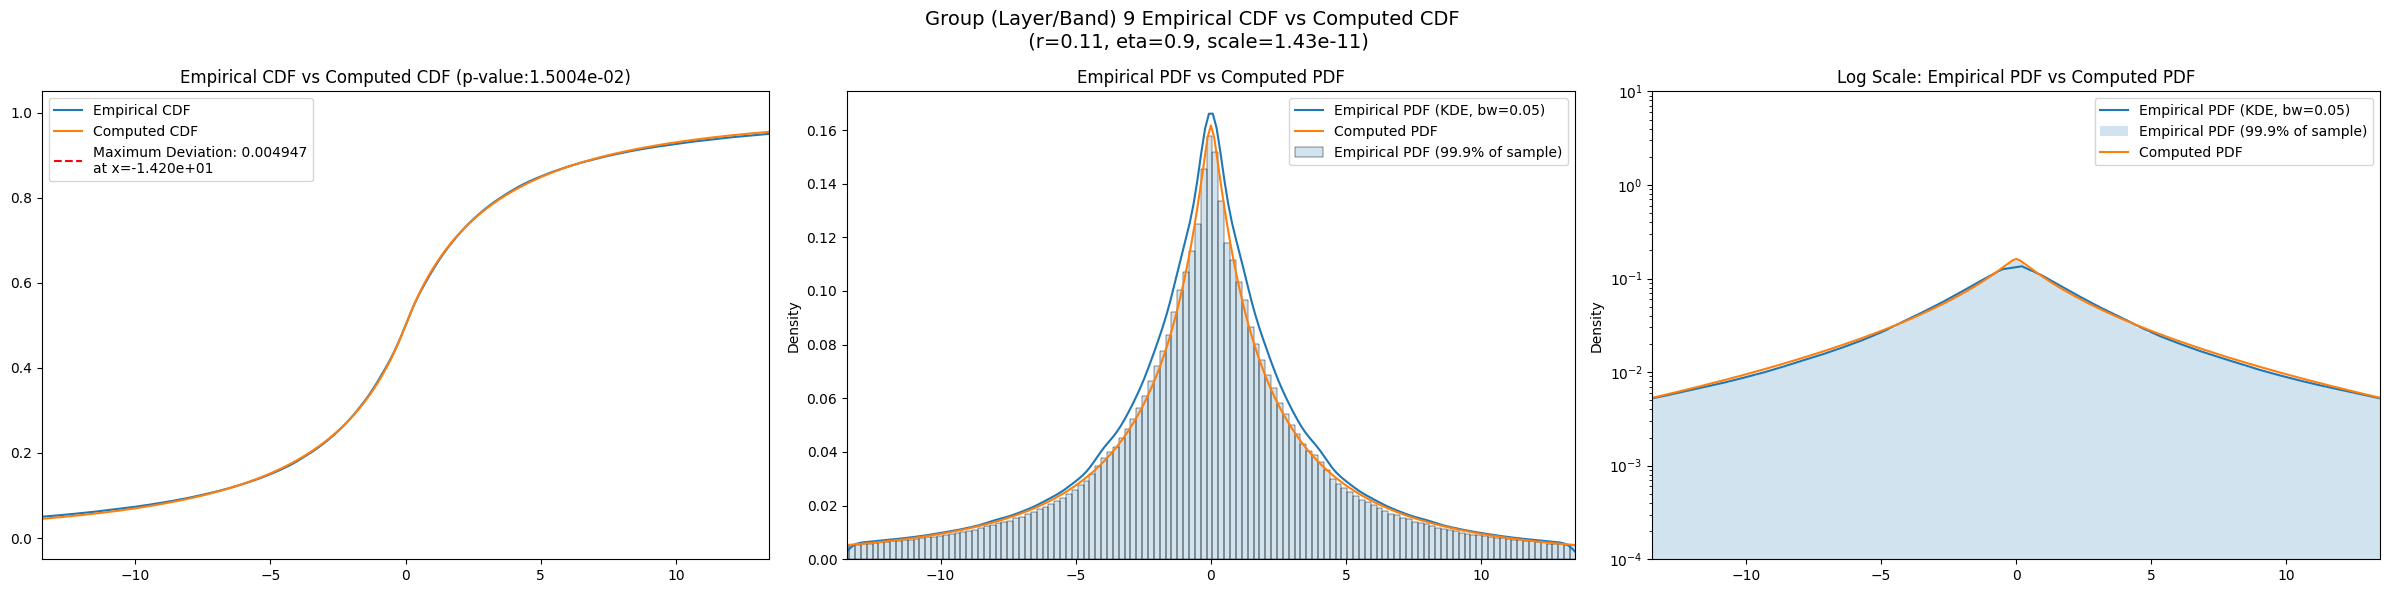

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.136796e+06,2.089662e+06,2.183364e+06,-1.757529,-1.772466,-1.739543,3396.0,0.193246,1.0,20.0,...,1993.40000,0.133515,2.969750e-53,1881.61000,0.149474,1.062700e-66,1593.3000,0.144807,1.313360e-62,1.458569e-111
4,1.684740e+05,1.600476e+05,1.771482e+05,1.874441,1.463638,2.318799,98808.0,0.005234,1.0,0.3,...,365.88900,0.018982,2.348600e-31,316.40200,0.014303,5.472920e-18,252.0320,0.019090,1.038010e-31,8.883911e-03
5,8.369902e+04,7.840057e+04,8.918237e+04,4.219650,3.506101,5.112777,524004.0,0.004149,0.5,-0.4,...,206.39200,0.040085,0.000000e+00,181.07800,0.012500,1.509060e-71,147.8360,0.014066,1.760140e-90,1.631861e-05
6,2.650260e+04,2.454781e+04,2.854205e+04,6.584359,5.694902,7.737797,2418270.0,0.005721,0.3,-0.3,...,97.73980,0.050043,0.000000e+00,85.98790,0.022975,0.000000e+00,69.1654,0.021027,0.000000e+00,2.259095e-55
7,6.867342e+03,6.302964e+03,7.459079e+03,8.624499,7.535332,9.846775,10234344.0,0.006487,0.2,-0.1,...,43.87690,0.053412,0.000000e+00,38.97580,0.027503,0.000000e+00,30.6928,0.024142,0.000000e+00,1.640199e-267
8,9.770067e+02,8.924991e+02,1.067059e+03,9.898498,8.096569,13.575704,42110360.0,0.007030,0.2,-0.1,...,16.11460,0.055413,0.000000e+00,14.32280,0.029565,0.000000e+00,11.2494,0.025885,0.000000e+00,0.000000e+00
9,9.496691e+01,8.462709e+01,1.075309e+02,19.474989,11.005217,47.744520,170911996.0,0.005407,0.1,1.2,...,4.81292,0.055251,0.000000e+00,4.27159,0.029129,0.000000e+00,3.3434,0.026255,0.000000e+00,0.000000e+00


## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0.193246,0.023255,0.193246,0.133515,0.149474,0.144807
4,0.005234,0.004319,0.005234,0.018982,0.014303,0.019090
5,0.004149,0.001876,0.003343,0.040085,0.012500,0.014066
6,0.005721,0.000873,0.005115,0.050043,0.022975,0.021027
7,0.006487,0.000425,0.005481,0.053412,0.027503,0.024142
8,0.007030,0.000209,0.006298,0.055413,0.029565,0.025885
9,0.005407,0.000104,0.005400,0.055251,0.029129,0.026255


In [20]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN
3,2.136796e+06,0.193246,1.00,20.00,9.938585e+04,0.0
4,1.684740e+05,0.005234,1.00,0.30,9.359664e+04,0.0
5,8.369902e+04,0.003343,0.55,-0.50,2.022694e+04,0.0
6,2.650260e+04,0.005115,0.25,-0.10,1.097096e+01,0.0
7,6.867342e+03,0.005481,0.20,-0.07,1.138054e-01,0.0
8,9.770067e+02,0.006298,0.20,-0.15,2.036437e-02,0.0
9,9.496691e+01,0.005400,0.11,0.90,1.429557e-11,0.0


In [21]:
eng.quit()